# INF266 Problem set 3: Exercise 5

## Imports

In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

## Task 1-3

In [2]:
# Load trajectories from pickle file
with open("trajectories.pickle", "rb") as f:
    trajectories = pickle.load(f)

In [3]:
# Explore the structure of the data
print(f"Number of trajectories: {len(trajectories)}")
print("Sample trajectory:")
print(trajectories[0])  # Print the first trajectory to understand the format

Number of trajectories: 1000
Sample trajectory:
[((np.int32(15), np.int32(0)), np.int64(0), np.float64(-0.5706047114070424), (np.int32(15), np.int32(1))), ((np.int32(15), np.int32(1)), np.int64(3), np.float64(-0.5706047114070424), (np.int32(16), np.int32(1))), ((np.int32(16), np.int32(1)), np.int64(3), np.float64(-0.5706047114070424), (np.int32(17), np.int32(1))), ((np.int32(17), np.int32(1)), np.int64(2), np.float64(-0.5691601425174042), (np.int32(16), np.int32(2))), ((np.int32(16), np.int32(2)), np.int64(2), np.float64(-0.5677155736277663), (np.int32(15), np.int32(3))), ((np.int32(15), np.int32(3)), np.int64(4), np.float64(-0.5794400900619951), (np.int32(16), np.int32(4))), ((np.int32(16), np.int32(4)), np.int64(0), np.float64(-0.56482643584849), (np.int32(16), np.int32(5))), ((np.int32(16), np.int32(5)), np.int64(3), np.float64(-0.6480179589432671), (np.int32(17), np.int32(5))), ((np.int32(17), np.int32(5)), np.int64(1), np.float64(-0.56482643584849), (np.int32(16), np.int32(5))), (

The trajectory data consists of state transitions in the format:
* (st,at,rt,st+1)

Where:
* st is the current state (grid position in the environment).
* at is the action taken at st
* rt is the reward recieved after taking action at
* st+1 is the next state after executing action at

Each trajectory represents a sequence of these transitions until termination.

### Monte Carlo Evaluation - State Value Function (First-Visit MC)

In [4]:
# Monte Carlo Evaluation - State Value Function
state_returns = defaultdict(list)
state_value_function = {}
policy = defaultdict(lambda: 0)  # Initial policy (default action 0)

gamma = 0.9  # Discount factor

In [5]:
for trajectory in trajectories:
    visited_states = set()
    G = 0
    for t in reversed(range(len(trajectory))):
        state, action, reward, next_state = trajectory[t]
        G = gamma * G + reward
        if state not in visited_states:
            state_returns[state].append(G)
            visited_states.add(state)

In [6]:
# Compute mean returns for each state
for state, returns in state_returns.items():
    state_value_function[state] = np.mean(returns)

In [7]:
# Print some computed state values
print("Computed State-Value Function (sample):")
for i, (state, value) in enumerate(state_value_function.items()):
    if i >= 10:
        break
    print(f"State {state}: {value:.3f}")

Computed State-Value Function (sample):
State (np.int32(21), np.int32(98)): -0.152
State (np.int32(21), np.int32(97)): -0.826
State (np.int32(22), np.int32(97)): -0.883
State (np.int32(21), np.int32(96)): -1.426
State (np.int32(21), np.int32(95)): -1.891
State (np.int32(22), np.int32(94)): -2.225
State (np.int32(23), np.int32(93)): -2.784
State (np.int32(22), np.int32(93)): -2.738
State (np.int32(21), np.int32(92)): -2.839
State (np.int32(20), np.int32(92)): -2.656


### Compute action-value function q_pi(a, s)

In [8]:
# Compute action-value function q_pi(a, s)
action_returns = defaultdict(list)
action_value_function = {}

for trajectory in trajectories:
    visited_state_action = set()
    G = 0
    for t in reversed(range(len(trajectory))):
        state, action, reward, next_state = trajectory[t]
        G = gamma * G + reward
        if (state, action) not in visited_state_action:
            action_returns[(state, action)].append(G)
            visited_state_action.add((state, action))

In [9]:
# Compute mean returns for each state-action pair
for state_action, returns in action_returns.items():
    action_value_function[state_action] = np.mean(returns)

In [10]:
# Print some computed action values
print("\nComputed Action-Value Function (sample):")
for i, ((state, action), value) in enumerate(action_value_function.items()):
    if i >= 10:
        break
    print(f"State {state}, Action {action}: {value:.3f}")


Computed Action-Value Function (sample):
State (np.int32(21), np.int32(98)), Action 1: -0.448
State (np.int32(21), np.int32(97)), Action 0: -0.466
State (np.int32(22), np.int32(97)), Action 1: -1.079
State (np.int32(21), np.int32(96)), Action 4: -1.078
State (np.int32(21), np.int32(95)), Action 2: -1.818
State (np.int32(22), np.int32(94)), Action 2: -2.153
State (np.int32(23), np.int32(93)), Action 2: -2.276
State (np.int32(22), np.int32(93)), Action 3: -2.977
State (np.int32(21), np.int32(92)), Action 4: -2.785
State (np.int32(20), np.int32(92)), Action 3: -2.839


### Plot State-Value Function

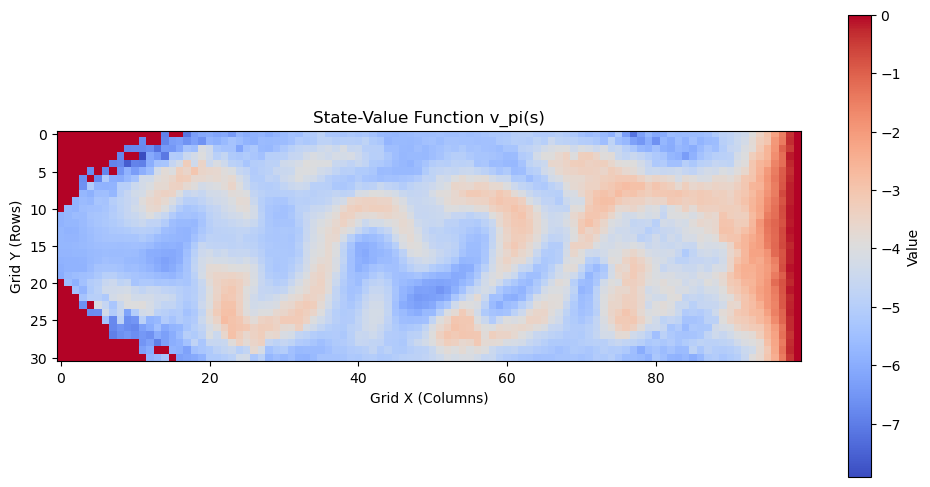

In [11]:
# Plot State-Value Function with grid size (31x100)
state_values = np.zeros((31, 100)) 
for (x, y), value in state_value_function.items():
    state_values[x, y] = value

plt.figure(figsize=(12, 6))
plt.imshow(state_values, cmap='coolwarm', origin='upper')
plt.colorbar(label="Value")
plt.title("State-Value Function v_pi(s)")
plt.xlabel("Grid X (Columns)")
plt.ylabel("Grid Y (Rows)")
plt.show()

## task 4-5

In [20]:
prev_policy = policy.copy()
policy_stable = True

for state in state_value_function.keys():
    best_action = None
    best_value = float('-inf')
    for action in range(5):  # Assuming 5 possible actions
        if (state, action) in action_value_function:
            if action_value_function[(state, action)] > best_value:
                best_value = action_value_function[(state, action)]
                best_action = action
    if best_action is not None:
        policy[state] = best_action
        if policy[state] != prev_policy[state]:
            policy_stable = False

In [21]:
# Print improved policy
print("\nImproved Policy:")
for state, action in policy.items():
    print(f"State {state}: Best Action {action}")


Improved Policy:
State (np.int32(21), np.int32(98)): Best Action 0
State (np.int32(21), np.int32(97)): Best Action 0
State (np.int32(22), np.int32(97)): Best Action 2
State (np.int32(21), np.int32(96)): Best Action 0
State (np.int32(21), np.int32(95)): Best Action 0
State (np.int32(22), np.int32(94)): Best Action 4
State (np.int32(23), np.int32(93)): Best Action 2
State (np.int32(22), np.int32(93)): Best Action 2
State (np.int32(21), np.int32(92)): Best Action 0
State (np.int32(20), np.int32(92)): Best Action 1
State (np.int32(21), np.int32(91)): Best Action 2
State (np.int32(22), np.int32(90)): Best Action 2
State (np.int32(22), np.int32(89)): Best Action 4
State (np.int32(21), np.int32(89)): Best Action 2
State (np.int32(22), np.int32(88)): Best Action 0
State (np.int32(23), np.int32(88)): Best Action 4
State (np.int32(22), np.int32(87)): Best Action 1
State (np.int32(23), np.int32(87)): Best Action 4
State (np.int32(22), np.int32(86)): Best Action 0
State (np.int32(22), np.int32(85

In [22]:
if policy_stable:
    print("\nThe policy has converged and is likely optimal.")
else:
    print("\nThe policy is still changing; further iterations or additional learning methods may be needed.")


The policy has converged and is likely optimal.


In [23]:
total_return = 0
num_episodes = len(trajectories)  # Evaluate on all trajectories
for trajectory in trajectories:
    G = 0
    for t in reversed(range(len(trajectory))):
        _, _, reward, _ = trajectory[t]
        G = gamma * G + reward
    total_return += G

avg_return = total_return / num_episodes
print(f"\nAverage Return from Policy Execution (All Trajectories): {avg_return:.3f}")


Average Return from Policy Execution (All Trajectories): -5.750


Is the new policy optimal?
* Average Return from Policy Execution is -5.750, which suggests that the policy is not fully optimal yet.
* The policy is still accumulating penalties or suboptimal rewards.